Step 1: Loading and exploring data...
=== Dataset Overview ===
Dataset shape: (19611, 79)
Memory usage: 13.28 MB

No missing values found!

Malware distribution:
Benign (0): 5012 (25.6%)
Malware (1): 14599 (74.4%)

Dataset Statistics:
Total samples: 19,611
Total features: 79
Numeric features: 78

Step 2: Preprocessing data...

=== Data Preprocessing ===
Selected 77 numeric features for analysis
Removing 8 zero-variance features
Final feature set: 69 features
Data preprocessing completed!

Step 3: Fitting Isolation Forest...

=== Fitting Isolation Forest ===

=== Tuning Isolation Forest Parameters ===
Contamination 0.05: AUC=0.331, F1=0.075, Precision=0.593, Recall=0.040, Anomalies=981
Contamination 0.10: AUC=0.331, F1=0.137, Precision=0.583, Recall=0.078, Anomalies=1950
Contamination 0.15: AUC=0.331, F1=0.207, Precision=0.617, Recall=0.124, Anomalies=2941
Contamination 0.20: AUC=0.331, F1=0.265, Precision=0.625, Recall=0.168, Anomalies=3922
Contamination 0.25: AUC=0.331, F1=0.311, Prec

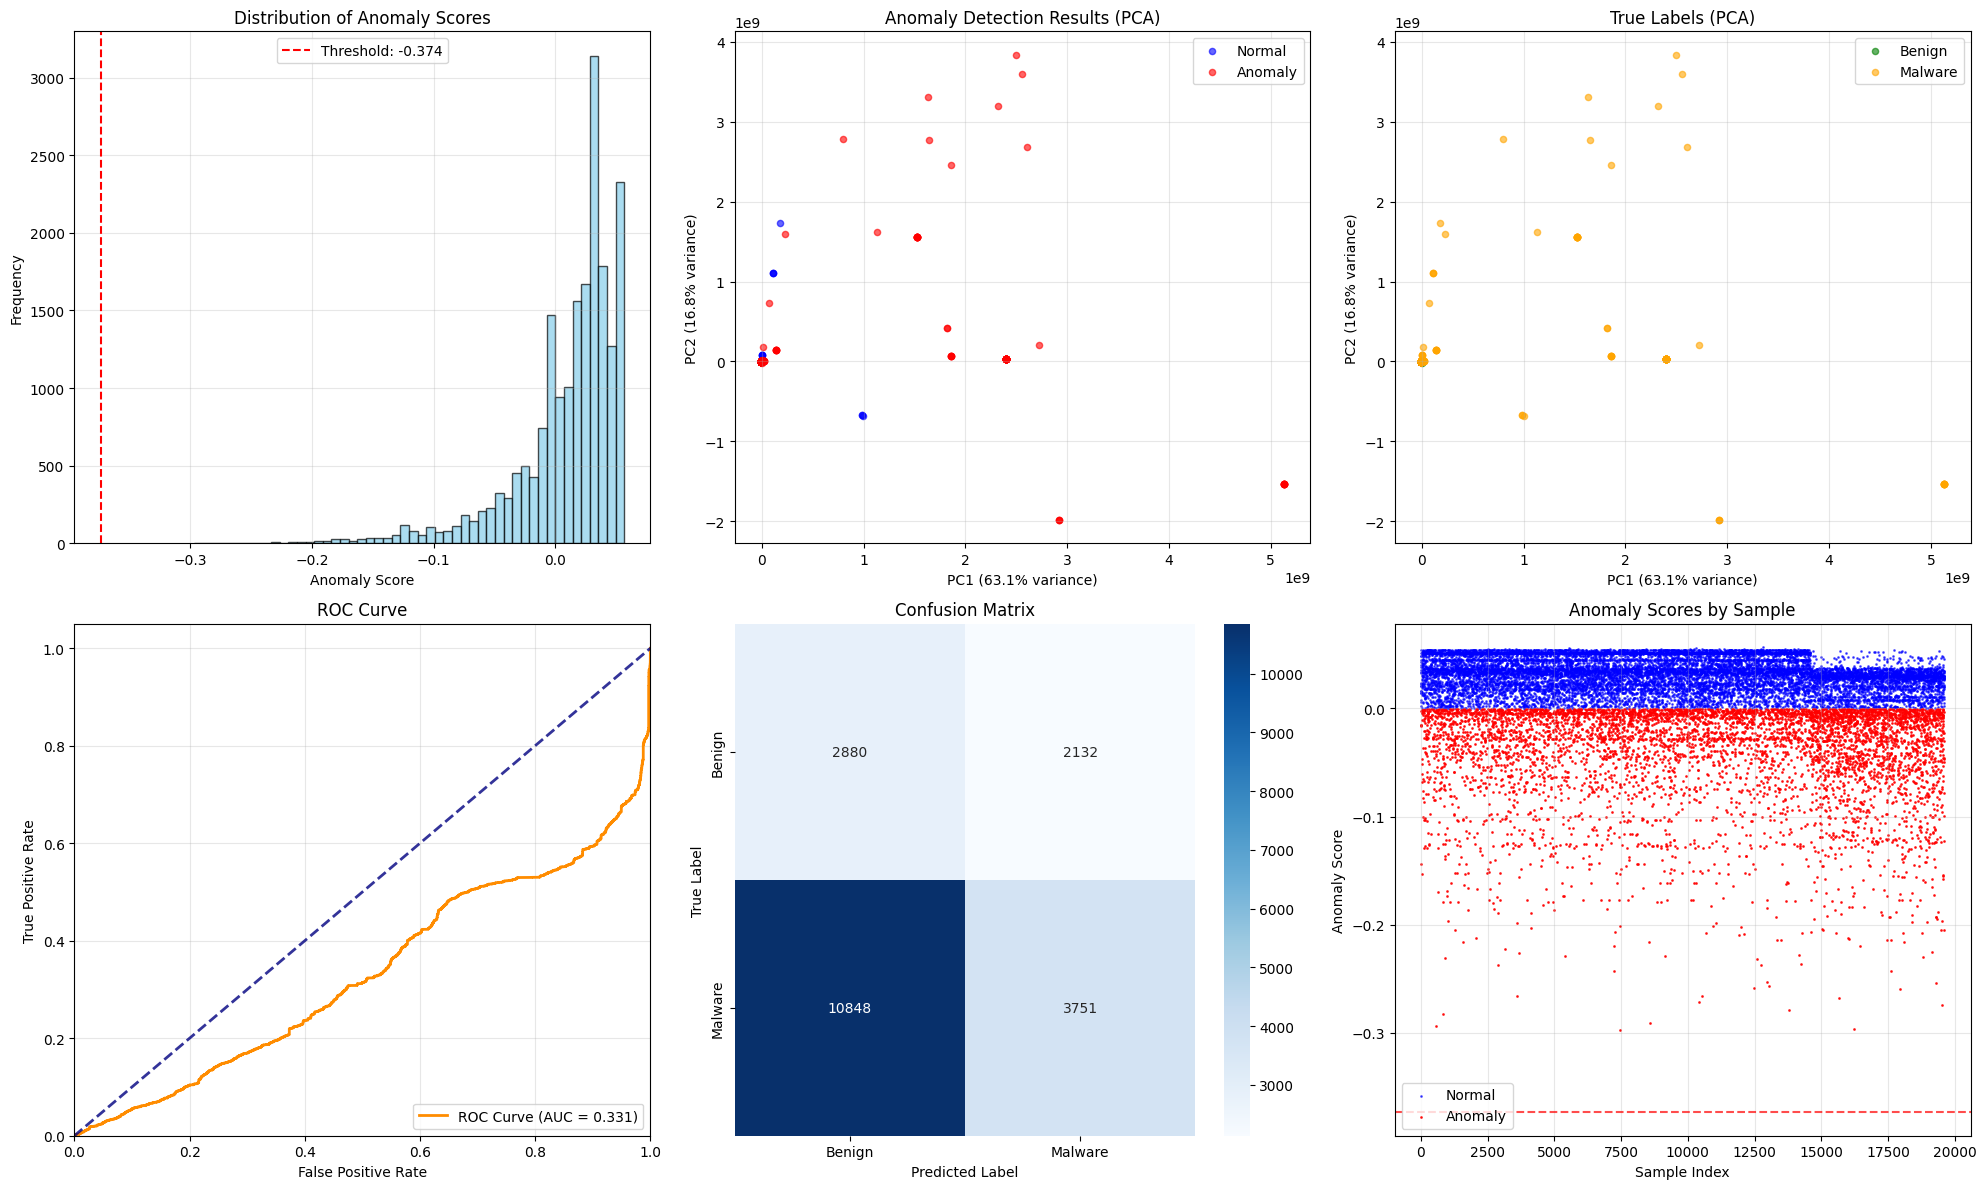


Step 6: Analyzing feature importance...

=== Feature Importance Analysis ===
Top 15 features most correlated with anomaly scores:
Rank                        Feature   |Correlation|   Raw Corr
-----------------------------------------------------------------
   1           SizeOfOptionalHeader          0.4105    -0.4105
   2                          Magic          0.3942    -0.3942
   3                        Machine          0.3942    -0.3942
   4                     e_maxalloc          0.3864     0.3864
   5                Characteristics          0.3571    -0.3571
   6                       e_lfarlc          0.2646    -0.2646
   7                        e_oemid          0.2528    -0.2528
   8                         e_ovno          0.2471    -0.2471
   9                      e_oeminfo          0.2448    -0.2448
  10           PointerToSymbolTable          0.2302    -0.2302
  11                           e_ip          0.2268    -0.2268
  12                           e_cs          0.

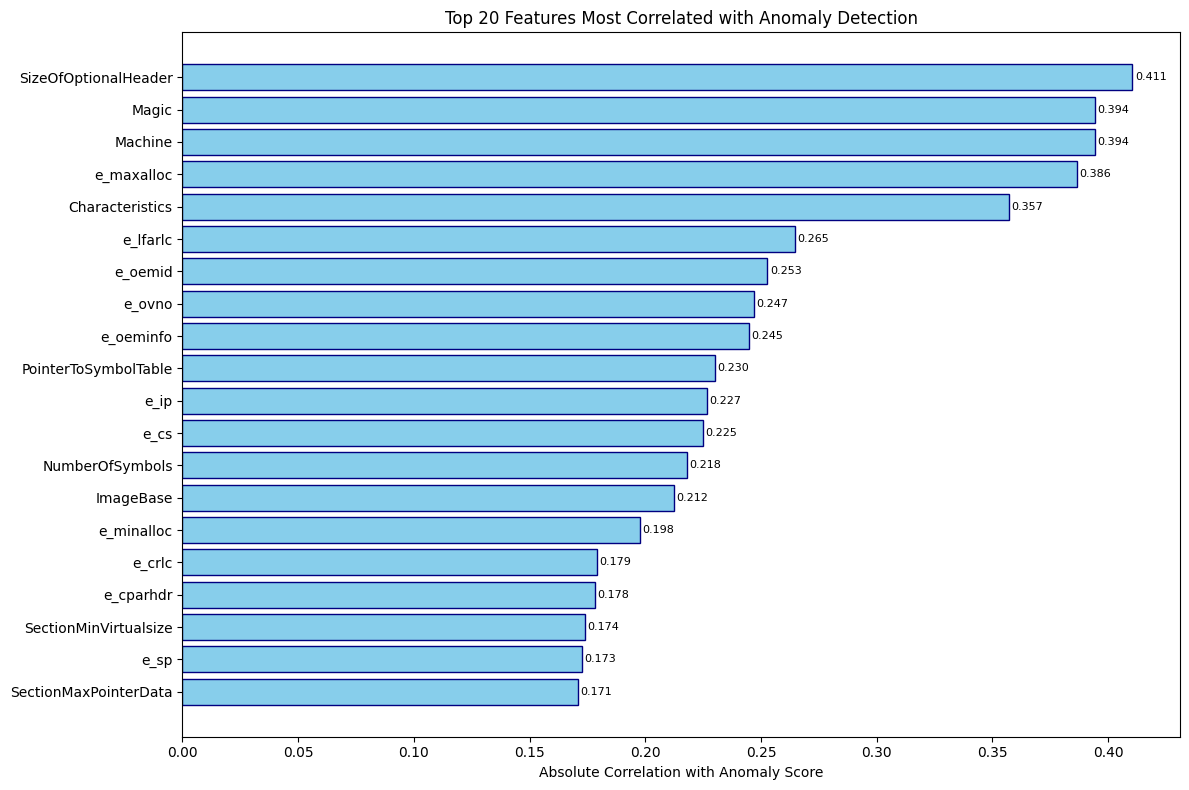


Step 7: Identifying top anomalies...

=== Top 15 Anomalies Analysis ===
Top 15 most anomalous samples:
Rank    Index   Anomaly Score   True Label                                        Sample Name
-----------------------------------------------------------------------------------------------
   1     7464         -0.2975      Malware        VirusShare_efb196a97675542010ea1e1cd2565a50
   2    16237         -0.2965       Benign                                            xul.dll
   3      558         -0.2944      Malware        VirusShare_effe5d950275994e4ae4475ade814c26
   4     8584         -0.2915      Malware        VirusShare_ef72a21bf5b4960c19a9e42de6162000
   5      848         -0.2831      Malware        VirusShare_efaed343612fcf59c60ee99f70c3d2f0
   6    13802         -0.2795      Malware        VirusShare_efdb7dc0f0e109b5fb98b1120d808dd7
   7    19520         -0.2746       Benign                                        sqllang.dll
   8    10424         -0.2721      Malware      

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

class MalwareIsolationForestAnalyzer:
    def __init__(self, csv_file_path):
        """Initialize the analyzer with the dataset"""
        self.df = pd.read_csv(csv_file_path)
        self.scaler = None
        self.isolation_forest = None
        self.pca_model = None
        self.X_scaled = None
        self.X_pca = None
        self.anomaly_scores = None
        self.anomaly_predictions = None
        
    def load_and_explore_data(self):
        """Load and explore the dataset"""
        print("=== Dataset Overview ===")
        print(f"Dataset shape: {self.df.shape}")
        print(f"Memory usage: {self.df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        
        # Check for missing values
        missing_vals = self.df.isnull().sum()
        if missing_vals.sum() > 0:
            print(f"\nMissing values found:")
            print(missing_vals[missing_vals > 0])
        else:
            print("\nNo missing values found!")
            
        # Target distribution
        if 'Malware' in self.df.columns:
            malware_dist = self.df['Malware'].value_counts()
            print(f"\nMalware distribution:")
            print(f"Benign (0): {malware_dist.get(0, 0)} ({malware_dist.get(0, 0)/len(self.df)*100:.1f}%)")
            print(f"Malware (1): {malware_dist.get(1, 0)} ({malware_dist.get(1, 0)/len(self.df)*100:.1f}%)")
            
        # Basic statistics
        print(f"\nDataset Statistics:")
        print(f"Total samples: {len(self.df):,}")
        print(f"Total features: {len(self.df.columns)}")
        print(f"Numeric features: {len(self.df.select_dtypes(include=[np.number]).columns)}")
        
        return self.df.head()
    
    def preprocess_data(self):
        """Preprocess the data for anomaly detection"""
        print("\n=== Data Preprocessing ===")
        
        # Separate features from target and identifier
        exclude_cols = ['Name', 'Malware'] if 'Name' in self.df.columns else ['Malware']
        if 'Malware' in self.df.columns:
            self.y_true = self.df['Malware'].values
        
        # Select numeric features only
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        feature_cols = [col for col in numeric_cols if col not in exclude_cols]
        
        self.X = self.df[feature_cols].copy()
        self.feature_names = feature_cols
        print(f"Selected {len(feature_cols)} numeric features for analysis")
        
        # Handle any remaining missing values
        self.X = self.X.fillna(self.X.median())
        
        # Remove features with zero variance
        zero_var_cols = self.X.columns[self.X.var() == 0]
        if len(zero_var_cols) > 0:
            print(f"Removing {len(zero_var_cols)} zero-variance features")
            self.X = self.X.drop(columns=zero_var_cols)
            self.feature_names = [col for col in self.feature_names if col not in zero_var_cols]
        
        # Scale the features using RobustScaler (less sensitive to outliers)
        self.scaler = RobustScaler()
        self.X_scaled = self.scaler.fit_transform(self.X)
        
        print(f"Final feature set: {self.X_scaled.shape[1]} features")
        print("Data preprocessing completed!")
        return self.X_scaled
    
    def tune_isolation_forest(self, contamination_range=None):
        """Find optimal contamination parameter for Isolation Forest"""
        if contamination_range is None:
            contamination_range = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
        
        print(f"\n=== Tuning Isolation Forest Parameters ===")
        
        results = []
        
        for contamination in contamination_range:
            # Fit Isolation Forest
            iso_forest = IsolationForest(
                contamination=contamination,
                random_state=42,
                n_estimators=100,
                max_samples='auto',
                n_jobs=-1
            )
            
            anomaly_pred = iso_forest.fit_predict(self.X_scaled)
            anomaly_scores = iso_forest.decision_function(self.X_scaled)
            
            # Convert predictions: -1 (anomaly) -> 1, 1 (normal) -> 0
            anomaly_pred_binary = (anomaly_pred == -1).astype(int)
            
            # Calculate metrics if true labels are available
            if hasattr(self, 'y_true'):
                # Calculate AUC score (higher anomaly scores should correspond to malware)
                auc_score = roc_auc_score(self.y_true, -anomaly_scores)  # Negative because lower scores = more anomalous
                
                # Calculate precision, recall for anomaly detection
                tp = np.sum((anomaly_pred_binary == 1) & (self.y_true == 1))
                fp = np.sum((anomaly_pred_binary == 1) & (self.y_true == 0))
                fn = np.sum((anomaly_pred_binary == 0) & (self.y_true == 1))
                
                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                
                results.append({
                    'contamination': contamination,
                    'n_anomalies': np.sum(anomaly_pred_binary),
                    'auc_score': auc_score,
                    'precision': precision,
                    'recall': recall,
                    'f1_score': f1
                })
                
                print(f"Contamination {contamination:.2f}: AUC={auc_score:.3f}, F1={f1:.3f}, "
                      f"Precision={precision:.3f}, Recall={recall:.3f}, Anomalies={np.sum(anomaly_pred_binary)}")
            else:
                results.append({
                    'contamination': contamination,
                    'n_anomalies': np.sum(anomaly_pred_binary)
                })
                print(f"Contamination {contamination:.2f}: Anomalies detected={np.sum(anomaly_pred_binary)}")
        
        # Convert to DataFrame for easier analysis
        results_df = pd.DataFrame(results)
        
        # Find optimal contamination based on F1 score (if available)
        if hasattr(self, 'y_true'):
            optimal_idx = results_df['f1_score'].idxmax()
            optimal_contamination = results_df.loc[optimal_idx, 'contamination']
            print(f"\nOptimal contamination based on F1 score: {optimal_contamination:.2f}")
        else:
            # If no true labels, suggest a moderate contamination
            optimal_contamination = 0.1
            print(f"\nNo true labels available. Using default contamination: {optimal_contamination:.2f}")
        
        return optimal_contamination, results_df
    
    def fit_isolation_forest(self, contamination='auto', n_estimators=100):
        """Fit the Isolation Forest model"""
        print(f"\n=== Fitting Isolation Forest ===")
        
        # If contamination is 'auto', tune it first
        if contamination == 'auto':
            contamination, tuning_results = self.tune_isolation_forest()
        
        print(f"Training Isolation Forest with contamination={contamination}")
        
        # Fit the final model
        self.isolation_forest = IsolationForest(
            contamination=contamination,
            random_state=42,
            n_estimators=n_estimators,
            max_samples='auto',
            n_jobs=-1,
            verbose=0
        )
        
        # Fit and predict
        self.anomaly_predictions = self.isolation_forest.fit_predict(self.X_scaled)
        self.anomaly_scores = self.isolation_forest.decision_function(self.X_scaled)
        
        # Convert predictions: -1 (anomaly) -> 1, 1 (normal) -> 0
        self.anomaly_predictions_binary = (self.anomaly_predictions == -1).astype(int)
        
        # Summary statistics
        n_anomalies = np.sum(self.anomaly_predictions_binary)
        anomaly_rate = n_anomalies / len(self.X_scaled) * 100
        
        print(f"Model fitting completed!")
        print(f"Anomalies detected: {n_anomalies:,} out of {len(self.X_scaled):,} samples ({anomaly_rate:.1f}%)")
        print(f"Anomaly score range: [{self.anomaly_scores.min():.3f}, {self.anomaly_scores.max():.3f}]")
        
        return self.anomaly_predictions_binary
    
    def evaluate_performance(self):
        """Evaluate the performance of anomaly detection"""
        if not hasattr(self, 'y_true'):
            print("No true labels available for performance evaluation")
            return None
            
        print("\n=== Performance Evaluation ===")
        
        # Classification report
        print("Classification Report (Anomaly Detection):")
        print(classification_report(self.y_true, self.anomaly_predictions_binary, 
                                   target_names=['Benign', 'Malware']))
        
        # Confusion Matrix
        cm = confusion_matrix(self.y_true, self.anomaly_predictions_binary)
        print(f"\nConfusion Matrix:")
        print(f"                 Predicted")
        print(f"                Benign  Malware")
        print(f"Actual Benign   {cm[0,0]:6d}  {cm[0,1]:6d}")
        print(f"       Malware  {cm[1,0]:6d}  {cm[1,1]:6d}")
        
        # ROC AUC Score
        auc_score = roc_auc_score(self.y_true, -self.anomaly_scores)  # Negative because lower = more anomalous
        print(f"\nROC AUC Score: {auc_score:.3f}")
        
        # Additional metrics
        tn, fp, fn, tp = cm.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"\nDetailed Metrics:")
        print(f"Precision (Malware Detection): {precision:.3f}")
        print(f"Recall (Malware Detection): {recall:.3f}")
        print(f"Specificity (Benign Detection): {specificity:.3f}")
        print(f"F1 Score: {f1:.3f}")
        
        return {
            'auc_score': auc_score,
            'precision': precision,
            'recall': recall,
            'specificity': specificity,
            'f1_score': f1,
            'confusion_matrix': cm
        }
    
    def visualize_results(self):
        """Create comprehensive visualizations"""
        print("\n=== Creating Visualizations ===")
        
        # Create PCA for visualization
        self.pca_model = PCA(n_components=2, random_state=42)
        self.X_pca = self.pca_model.fit_transform(self.X_scaled)
        explained_variance = self.pca_model.explained_variance_ratio_
        
        # Create figure with subplots
        fig = plt.figure(figsize=(20, 12))
        
        # 1. Anomaly Score Distribution
        ax1 = plt.subplot(2, 3, 1)
        plt.hist(self.anomaly_scores, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(self.isolation_forest.offset_, color='red', linestyle='--', 
                   label=f'Threshold: {self.isolation_forest.offset_:.3f}')
        plt.xlabel('Anomaly Score')
        plt.ylabel('Frequency')
        plt.title('Distribution of Anomaly Scores')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. PCA Visualization - Anomaly Predictions
        ax2 = plt.subplot(2, 3, 2)
        colors = ['blue', 'red']
        labels = ['Normal', 'Anomaly']
        for i, (color, label) in enumerate(zip(colors, labels)):
            mask = self.anomaly_predictions_binary == i
            plt.scatter(self.X_pca[mask, 0], self.X_pca[mask, 1], 
                       c=color, alpha=0.6, s=20, label=label)
        plt.xlabel(f'PC1 ({explained_variance[0]:.1%} variance)')
        plt.ylabel(f'PC2 ({explained_variance[1]:.1%} variance)')
        plt.title('Anomaly Detection Results (PCA)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 3. PCA Visualization - True Labels (if available)
        ax3 = plt.subplot(2, 3, 3)
        if hasattr(self, 'y_true'):
            colors = ['green', 'orange']
            labels = ['Benign', 'Malware']
            for i, (color, label) in enumerate(zip(colors, labels)):
                mask = self.y_true == i
                plt.scatter(self.X_pca[mask, 0], self.X_pca[mask, 1], 
                           c=color, alpha=0.6, s=20, label=label)
            plt.xlabel(f'PC1 ({explained_variance[0]:.1%} variance)')
            plt.ylabel(f'PC2 ({explained_variance[1]:.1%} variance)')
            plt.title('True Labels (PCA)')
            plt.legend()
        else:
            plt.text(0.5, 0.5, 'No True Labels\nAvailable', 
                    ha='center', va='center', transform=ax3.transAxes, fontsize=14)
            plt.title('True Labels (Not Available)')
        plt.grid(True, alpha=0.3)
        
        # 4. ROC Curve (if true labels available)
        ax4 = plt.subplot(2, 3, 4)
        if hasattr(self, 'y_true'):
            fpr, tpr, thresholds = roc_curve(self.y_true, -self.anomaly_scores)
            auc_score = roc_auc_score(self.y_true, -self.anomaly_scores)
            plt.plot(fpr, tpr, color='darkorange', lw=2, 
                    label=f'ROC Curve (AUC = {auc_score:.3f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.8)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.legend(loc="lower right")
        else:
            plt.text(0.5, 0.5, 'ROC Curve\nRequires True Labels', 
                    ha='center', va='center', transform=ax4.transAxes, fontsize=14)
            plt.title('ROC Curve (Not Available)')
        plt.grid(True, alpha=0.3)
        
        # 5. Confusion Matrix Heatmap (if true labels available)
        ax5 = plt.subplot(2, 3, 5)
        if hasattr(self, 'y_true'):
            cm = confusion_matrix(self.y_true, self.anomaly_predictions_binary)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=['Benign', 'Malware'],
                       yticklabels=['Benign', 'Malware'])
            plt.title('Confusion Matrix')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
        else:
            plt.text(0.5, 0.5, 'Confusion Matrix\nRequires True Labels', 
                    ha='center', va='center', transform=ax5.transAxes, fontsize=14)
            plt.title('Confusion Matrix (Not Available)')
        
        # 6. Anomaly Score vs Sample Index
        ax6 = plt.subplot(2, 3, 6)
        sample_indices = np.arange(len(self.anomaly_scores))
        plt.scatter(sample_indices[self.anomaly_predictions_binary == 0], 
                   self.anomaly_scores[self.anomaly_predictions_binary == 0],
                   c='blue', alpha=0.6, s=1, label='Normal')
        plt.scatter(sample_indices[self.anomaly_predictions_binary == 1], 
                   self.anomaly_scores[self.anomaly_predictions_binary == 1],
                   c='red', alpha=0.8, s=1, label='Anomaly')
        plt.axhline(self.isolation_forest.offset_, color='red', linestyle='--', alpha=0.7)
        plt.xlabel('Sample Index')
        plt.ylabel('Anomaly Score')
        plt.title('Anomaly Scores by Sample')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def analyze_feature_importance(self):
        """Analyze which features contribute most to anomaly detection"""
        print("\n=== Feature Importance Analysis ===")
        
        # For Isolation Forest, we can analyze feature importance by looking at
        # the path lengths in the trees, but sklearn doesn't directly provide this
        # Instead, we'll use a correlation-based approach
        
        # Calculate correlation between features and anomaly scores
        feature_correlations = []
        for i, feature_name in enumerate(self.feature_names):
            if feature_name in self.X.columns:
                corr = np.corrcoef(self.X[feature_name], self.anomaly_scores)[0, 1]
                feature_correlations.append({
                    'feature': feature_name,
                    'correlation': abs(corr),  # Use absolute value
                    'raw_correlation': corr
                })
        
        # Sort by absolute correlation
        feature_correlations.sort(key=lambda x: x['correlation'], reverse=True)
        
        print("Top 15 features most correlated with anomaly scores:")
        print(f"{'Rank':>4} {'Feature':>30} {'|Correlation|':>15} {'Raw Corr':>10}")
        print("-" * 65)
        for i, item in enumerate(feature_correlations[:15]):
            print(f"{i+1:4d} {item['feature']:>30} {item['correlation']:>15.4f} {item['raw_correlation']:>10.4f}")
        
        # Visualize top features
        top_features = feature_correlations[:20]
        feature_names_top = [item['feature'] for item in top_features]
        correlations_top = [item['correlation'] for item in top_features]
        
        plt.figure(figsize=(12, 8))
        y_pos = np.arange(len(feature_names_top))
        bars = plt.barh(y_pos, correlations_top, color='skyblue', edgecolor='navy')
        plt.yticks(y_pos, feature_names_top)
        plt.xlabel('Absolute Correlation with Anomaly Score')
        plt.title('Top 20 Features Most Correlated with Anomaly Detection')
        plt.gca().invert_yaxis()
        
        # Add correlation values on bars
        for i, bar in enumerate(bars):
            width = bar.get_width()
            plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                    f'{width:.3f}', ha='left', va='center', fontsize=8)
        
        plt.tight_layout()
        plt.show()
        
        return feature_correlations
    
    def identify_top_anomalies(self, n_top=10):
        """Identify and analyze the top anomalies"""
        print(f"\n=== Top {n_top} Anomalies Analysis ===")
        
        # Get indices of top anomalies (lowest scores)
        anomaly_indices = np.argsort(self.anomaly_scores)[:n_top]
        
        print(f"Top {n_top} most anomalous samples:")
        print(f"{'Rank':>4} {'Index':>8} {'Anomaly Score':>15} {'True Label':>12} {'Sample Name':>50}")
        print("-" * 95)
        
        for rank, idx in enumerate(anomaly_indices):
            score = self.anomaly_scores[idx]
            true_label = self.y_true[idx] if hasattr(self, 'y_true') else 'Unknown'
            true_label_str = 'Malware' if true_label == 1 else ('Benign' if true_label == 0 else 'Unknown')
            sample_name = self.df.iloc[idx]['Name'] if 'Name' in self.df.columns else f'Sample_{idx}'
            
            print(f"{rank+1:4d} {idx:8d} {score:15.4f} {true_label_str:>12} {sample_name:>50}")
        
        # Analyze characteristics of top anomalies
        if hasattr(self, 'y_true'):
            anomaly_labels = self.y_true[anomaly_indices]
            malware_count = np.sum(anomaly_labels)
            benign_count = len(anomaly_labels) - malware_count
            
            print(f"\nComposition of top {n_top} anomalies:")
            print(f"Malware: {malware_count} ({malware_count/n_top*100:.1f}%)")
            print(f"Benign: {benign_count} ({benign_count/n_top*100:.1f}%)")
        
        return anomaly_indices
    
    def generate_summary_report(self):
        """Generate a comprehensive summary report"""
        print("\n" + "="*70)
        print("MALWARE ISOLATION FOREST ANOMALY DETECTION SUMMARY")
        print("="*70)
        
        if self.isolation_forest is not None:
            contamination = self.isolation_forest.contamination
            n_estimators = self.isolation_forest.n_estimators
            n_anomalies = np.sum(self.anomaly_predictions_binary)
            anomaly_rate = n_anomalies / len(self.X_scaled) * 100
            
            print(f"Dataset: {self.df.shape[0]:,} samples, {self.X_scaled.shape[1]} features")
            print(f"Model: Isolation Forest (n_estimators={n_estimators}, contamination={contamination})")
            print(f"Anomalies detected: {n_anomalies:,} ({anomaly_rate:.1f}%)")
            print(f"Anomaly score range: [{self.anomaly_scores.min():.3f}, {self.anomaly_scores.max():.3f}]")
            
            if hasattr(self, 'y_true'):
                # Performance metrics
                cm = confusion_matrix(self.y_true, self.anomaly_predictions_binary)
                tn, fp, fn, tp = cm.ravel()
                
                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                auc_score = roc_auc_score(self.y_true, -self.anomaly_scores)
                
                print(f"\nPerformance Metrics:")
                print(f"  ROC AUC Score: {auc_score:.3f}")
                print(f"  Precision: {precision:.3f}")
                print(f"  Recall: {recall:.3f}")
                print(f"  F1 Score: {f1:.3f}")
                
                print(f"\nConfusion Matrix:")
                print(f"  True Positive (Malware detected): {tp:,}")
                print(f"  False Positive (Benign flagged): {fp:,}")
                print(f"  True Negative (Benign correct): {tn:,}")
                print(f"  False Negative (Malware missed): {fn:,}")
                
                # Analysis of anomalies vs true labels
                anomaly_malware = np.sum(self.anomaly_predictions_binary & self.y_true)
                anomaly_benign = np.sum(self.anomaly_predictions_binary & (1 - self.y_true))
                
                print(f"\nAnomaly Composition:")
                print(f"  Malware flagged as anomalies: {anomaly_malware:,} ({anomaly_malware/n_anomalies*100:.1f}%)")
                print(f"  Benign flagged as anomalies: {anomaly_benign:,} ({anomaly_benign/n_anomalies*100:.1f}%)")
        
        print(f"\nKey Insights:")
        print("• Isolation Forest identifies samples with unusual feature combinations")
        print("• Lower anomaly scores indicate higher likelihood of being anomalous")
        print("• Effective for detecting new/unknown malware variants")
        print("• Consider investigating samples with very low anomaly scores")
        
        print("="*70)

# Main execution function
def main(csv_file_path='/Users/sfsmith/AICS/Antimalware/dataset_malwares.csv'):
    """Run complete Isolation Forest analysis"""
    
    # Initialize analyzer
    analyzer = MalwareIsolationForestAnalyzer(csv_file_path)
    
    # Step 1: Load and explore data
    print("Step 1: Loading and exploring data...")
    sample_data = analyzer.load_and_explore_data()
    
    # Step 2: Preprocess data
    print("\nStep 2: Preprocessing data...")
    X_scaled = analyzer.preprocess_data()
    
    # Step 3: Fit Isolation Forest with automatic tuning
    print("\nStep 3: Fitting Isolation Forest...")
    anomaly_predictions = analyzer.fit_isolation_forest(contamination='auto')
    
    # Step 4: Evaluate performance (if true labels available)
    print("\nStep 4: Evaluating performance...")
    performance_metrics = analyzer.evaluate_performance()
    
    # Step 5: Create visualizations
    print("\nStep 5: Creating visualizations...")
    analyzer.visualize_results()
    
    # Step 6: Analyze feature importance
    print("\nStep 6: Analyzing feature importance...")
    feature_importance = analyzer.analyze_feature_importance()
    
    # Step 7: Identify top anomalies
    print("\nStep 7: Identifying top anomalies...")
    top_anomalies = analyzer.identify_top_anomalies(n_top=15)
    
    # Step 8: Generate summary report
    print("\nStep 8: Generating summary report...")
    analyzer.generate_summary_report()
    
    return analyzer

if __name__ == "__main__":
    # Update this path to match your file location
    csv_file_path = '/Users/sfsmith/AICS/Antimalware/dataset_malwares.csv'
    # below is the test data set after we train to see if we get similar results
    # csv_file_path = '/Users/sfsmith/AICS/Antimalware/dataset_test.csv'
    
    # Run the complete analysis
    analyzer = main(csv_file_path)
    
    # Optional: Save results
    if analyzer.anomaly_predictions_binary is not None:
        results_df = pd.DataFrame({
            'Sample_Index': range(len(analyzer.anomaly_predictions_binary)),
            'Sample_Name': analyzer.df['Name'] if 'Name' in analyzer.df.columns else [f'Sample_{i}' for i in range(len(analyzer.df))],
            'Anomaly_Score': analyzer.anomaly_scores,
            'Is_Anomaly': analyzer.anomaly_predictions_binary,
            'True_Label': analyzer.y_true if hasattr(analyzer, 'y_true') else [None] * len(analyzer.anomaly_predictions_binary)
        })
        
        # Sort by anomaly score (most anomalous first)
        results_df = results_df.sort_values('Anomaly_Score')
        
        # Save to CSV
        output_file = 'isolation_forest_results.csv'
        results_df.to_csv(output_file, index=False)
        print(f"\nResults saved to '{output_file}'")
        
        # Show top 10 anomalies
        print(f"\nTop 10 most anomalous samples:")
        print(results_df.head(10)[['Sample_Name', 'Anomaly_Score', 'Is_Anomaly', 'True_Label']].to_string(index=False))